(None, None)

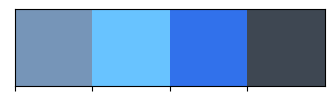

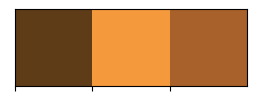

In [1]:
import seaborn as sns
import glob
import numpy as np
from natsort import natsorted
import matplotlib.pyplot as plt
from scipy.stats import mannwhitneyu as mu

selected_variables_mouse = ['Pupil Size', 'Nose Mov', 'Eye [x]', 'Eye [y]', 'Nose [x]', 'Nose [y]', 'Whiskers [x]', 'Whiskers [y]']
all_vars_macaque  = ['Pupil Size', 'Eye Mov', 'Eye [x]', 'Eye [y]', 'rEar [x]', 'rEar [y]', 'lEar [x]', 'lEar [y]', 'rEyeBr [x]', 'rEyeBr [y]', 'lEyeBr [x]', 
                    'nostrils [x]', 'nostrils [y]', 'uLip [x]', 'uLip [y]', 'lLip [x]', 'lLip [y]']
newOrder_mouse = np.array([0, 2, 3, 1, 4, 5, 6, 7])
newOrder_macaque = np.array([0,1,2,3,8,9,10,11,12,13,14,15,16,4,5,6,7])

stat_labs = [np.array(['A', 'B', 'C', 'D']), np.array(['A', 'B', 'C'])]

cols_macaque = sns.color_palette(np.array(['#7695B8','#68c3ffff', "#3171eb", "#3e4752ff"]))
cols_mouse = sns.color_palette(np.array(["#5E3C18", "#F5993D", "#A8612A"]))

sns.palplot(cols_macaque), sns.palplot(cols_mouse)

In [2]:
from sklearn.metrics import r2_score
numTrials = 100

date = '11122023'
date_mouse = '27022024'

files_results_macaque_decorr = natsorted(glob.glob('Results/Macaque/Results_Test_sLDS_Optuna_macaque_100trials_'+date+'_RT_noLEyeBrModel_AllSubjects_session*.npz', recursive = True))
files_results_mouse_decorr = natsorted(glob.glob('Results/Mouse/Results_Test_MSLR_Optuna_mouse_newDLC_100trials_'+date_mouse+'_RT_AllSubjects_session*.npz', recursive = True))
with open('RawData/Macaque/files_logs_macaque_moreSes.txt') as f:
    files_logs_macaque = [line.strip() for line in f.readlines()]
    
with open('RawData/Mouse/files_logs_mouse_moreSes.txt') as f:
    files_logs_mouse = [line.strip() for line in f.readlines()]

subjects_macaque = ['Cosmos', 'Karl']
stickiness_macaque, concentration_macaque, predictions_macaque, X_test_macaque, y_test_macaque, numStates_macaque, predicted_states_macaque, predicted_statesProbs_macaque, transitionMatrices_macaque, weights_macaque, errorTrials_macaque = [], [], [], [], [], [], [], [], [], [], []
cv_scores_macaque = []
for file in files_results_macaque_decorr:
    a = np.load(file, allow_pickle = True)

    X_test_macaque.append(a[a.files[0]][()]['X_test'])
    y_test_macaque.append(a[a.files[0]][()]['y_test'])
    predictions_macaque.append(a[a.files[0]][()]['predictions'])
    numStates_macaque.append(a[a.files[0]][()]['numStates'])
    concentration_macaque.append(a[a.files[0]][()]['concentration'])
    stickiness_macaque.append(a[a.files[0]][()]['stickiness'])
    predicted_states_macaque.append(a[a.files[0]][()]['predicted_states'])
    predicted_statesProbs_macaque.append(a[a.files[0]][()]['predicted_statesProbs'])
    transitionMatrices_macaque.append(a[a.files[0]][()]['transitionMatrices'])
    weights_macaque.append(a[a.files[0]][()]['weights'])

numShuff = 100
perf_macaque = np.full(len(y_test_macaque), np.nan)
perf_macaque_Sh = np.full((len(y_test_macaque), numShuff), np.nan)

for i in range(len(y_test_macaque)):
    preds = np.array(predictions_macaque[i])
    preds[preds<0] = 0
    perf_macaque[i] = r2_score(y_test_macaque[i], preds)#, squared = False)
    for s in np.arange(numShuff):
        perf_macaque_Sh[i,s] = r2_score(y_test_macaque[i], np.random.permutation(y_test_macaque[i]))#, squared = False)

    
subjects_mouse = ['001', '003', '004', '005', '012', '013']
stickiness_mouse, concentration_mouse, predictions_mouse, X_test_mouse, y_test_mouse, numStates_mouse, predicted_states_mouse, predicted_statesProbs_mouse, transitionMatrices_mouse, weights_mouse, errorTrials_mouse = [], [], [], [], [], [], [], [], [], [], []
cv_scores_mouse = []
for file in files_results_mouse_decorr:
    a = np.load(file, allow_pickle = True)

    X_test_mouse.append(a[a.files[0]][()]['X_test'])
    y_test_mouse.append(a[a.files[0]][()]['y_test'])
    predictions_mouse.append(a[a.files[0]][()]['predictions'])
    numStates_mouse.append(a[a.files[0]][()]['numStates'])
    concentration_mouse.append(a[a.files[0]][()]['concentration'])
    stickiness_mouse.append(a[a.files[0]][()]['stickiness'])
    predicted_states_mouse.append(a[a.files[0]][()]['predicted_states'])
    predicted_statesProbs_mouse.append(a[a.files[0]][()]['predicted_statesProbs'])
    transitionMatrices_mouse.append(a[a.files[0]][()]['transitionMatrices'])
    weights_mouse.append(a[a.files[0]][()]['weights'])

numShuff = 100
perf_mouse = np.full(len(y_test_mouse), np.nan)
perf_mouse_Sh = np.full((len(y_test_mouse), numShuff), np.nan)

for i in range(len(y_test_mouse)):
    preds = np.array(predictions_mouse[i])
    preds[preds<0] = 0
    perf_mouse[i] = r2_score(y_test_mouse[i], preds)#, squared = False)
    for s in np.arange(numShuff):
        perf_mouse_Sh[i,s] = r2_score(y_test_mouse[i], np.random.permutation(y_test_mouse[i]))#, squared = False)

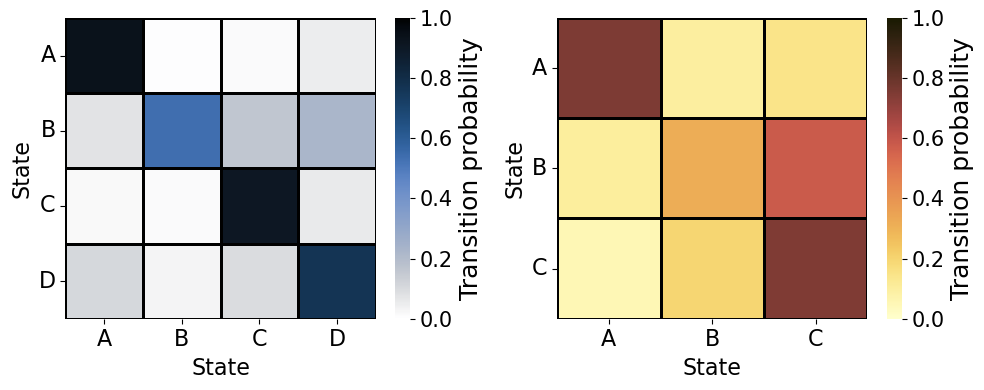

In [3]:
import cmcrameri as cmc
fig, ax = plt.subplots(ncols = 2, figsize = (10, 4))
num_states_macaque = transitionMatrices_macaque[0].shape[0]
num_states_mouse = transitionMatrices_mouse[0].shape[0]
mask = np.array(transitionMatrices_macaque[0]) < 0.1

hm1 = sns.heatmap(transitionMatrices_macaque[0], vmin = 0, vmax = 1, cbar = True, ax = ax[0],
        cmap = 'cmc.oslo_r', cbar_kws = {'label':'Transition probability'}, annot = False, fmt = '.2g', annot_kws={'fontsize':14}, linewidth = 1, linecolor = 'black')
hm1.figure.axes[-1].yaxis.label.set_size(18)
cbar = ax[0].collections[0].colorbar
# here set the labelsize b
cbar.ax.tick_params(labelsize=15)

mask = np.array(transitionMatrices_mouse[0]) < 0.1
hm2 = sns.heatmap(transitionMatrices_mouse[0], vmin = 0, vmax = 1, cbar = True, ax = ax[1],
        cmap = 'cmc.lajolla', cbar_kws = {'label':'Transition probability'}, annot = False, fmt = '.2g', annot_kws={'fontsize':14}, linewidth = 1, linecolor = 'black')

hm2.figure.axes[-1].yaxis.label.set_size(18)
cbar = ax[1].collections[0].colorbar
cbar.ax.tick_params(labelsize=15)
for axi in ax:
    axi.set_ylabel('State', fontsize = 16)
    axi.set_xlabel('State', fontsize = 16)
ax[0].set_yticks(ticks = np.arange(num_states_macaque)+0.5, labels = stat_labs[0], fontsize = 16, rotation = 0)
ax[0].set_xticks(ticks = np.arange(num_states_macaque)+0.5, labels = stat_labs[0], fontsize = 16)
ax[1].set_yticks(ticks = np.arange(num_states_mouse)+0.5, labels = stat_labs[1], fontsize = 16, rotation = 0)
ax[1].set_xticks(ticks = np.arange(num_states_mouse)+0.5, labels = stat_labs[1], fontsize = 16)
plt.tight_layout()

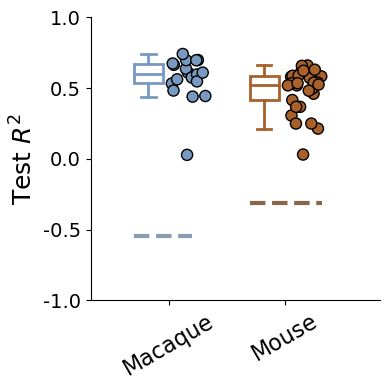

In [4]:
fig, ax = plt.subplots(figsize=(4,4))
sns.despine()
cus_pal = sns.color_palette(['#7899c2ff', '#A8612A'])

sns.boxplot(data = [perf_macaque, perf_mouse], palette = cus_pal ,showfliers = False, width=0.25, linewidth = 2)

for i, artist in enumerate(ax.patches):
        # Set the linecolor on the artist to the facecolor, and set the facecolor to None
        artist.set_edgecolor(cus_pal[i])
        artist.set_facecolor('None')
        # Each box has 5 associated Line2D objects (because there are no outliers)
        # Loop over them here, and use the same colour as above
        for j in range(i*5,i*5+5):
            line = ax.lines[j]
            line.set_color(cus_pal[i])
            line.set_lw(2)
            line.set_mfc(cus_pal[i])
            line.set_mec(cus_pal[i])


sns.stripplot(data=[perf_macaque, perf_mouse], palette=cus_pal, jitter=0.15, alpha=1, edgecolor='black', linewidth=1, ax=ax, zorder = 1, dodge=False, size = 8)

# adjust x-limits to make room for stripplot
ax.set_xlim(ax.get_xlim()[0], ax.get_xlim()[1] + 0.5)
# shift the stripplot to the right
for line in ax.collections:
    x, y = line.get_offsets().T
    line.set_offsets(np.c_[x + 0.35, y])
    
ax.set_xticks(ticks = np.arange(2)+0.1775, labels = ['Macaque', 'Mouse'], fontsize = 16, rotation = 30)
ax.set_yticks(ticks = np.linspace(-1, 1, 5), labels = ['{:.1f}'.format(a) for a in np.linspace(-1, 1, 5)], fontsize = 14)
ax.set_ylabel('Test $R^2$', fontsize = 18)
plt.axhline(np.percentile(perf_macaque_Sh,99), xmin = 0.15, xmax = 0.35, color = sns.desaturate('#7899c2ff',0.5), lw = 3, ls = '--')
plt.axhline(np.percentile(perf_mouse_Sh,99), xmin = 0.55, xmax = 0.8, color = sns.desaturate('#A8612A',0.5),  alpha = 1, lw = 3, ls = '--')
plt.tight_layout()

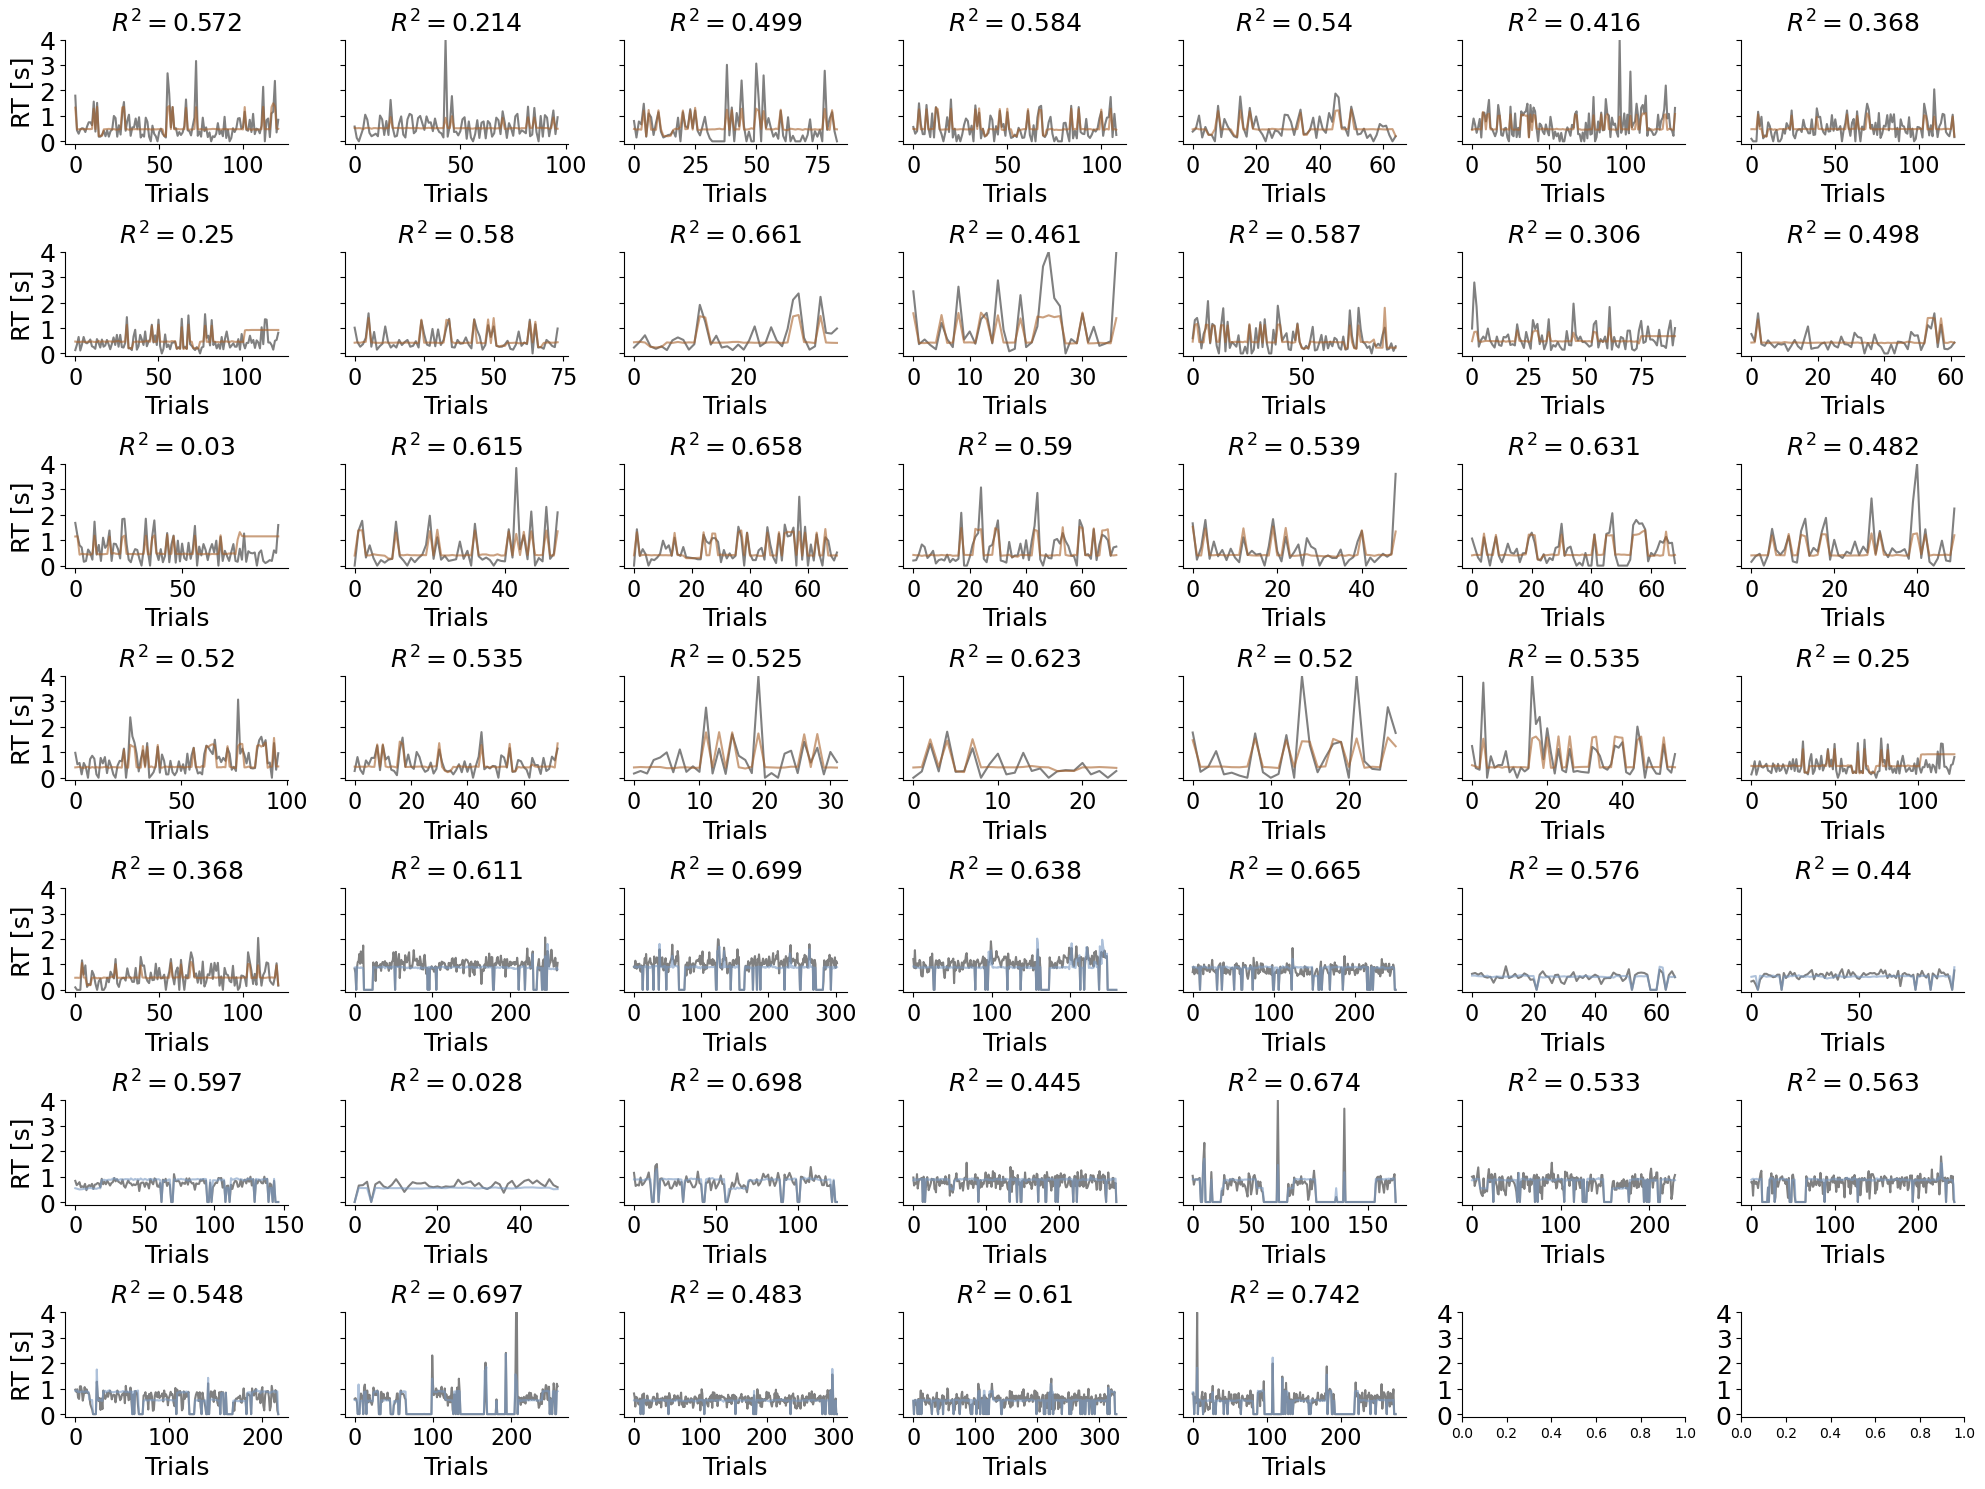

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

# New figure size, and subplot configuration
totalRows, totalCols = 7,7  
fig, ax = plt.subplots(nrows=totalRows, ncols=totalCols, figsize=(20, 15))

for axi in ax.flat:
    axi.set_ylim([-0.1, 4])
    axi.set_yticks(np.linspace(0, 4, 5), labels = np.linspace(0, 4, 5).astype(int), fontsize = 18)
# Plotting the mouse data
counter = 0
for axi in ax.flat[:len(perf_mouse)]: 
    r2 = metrics.r2_score(y_test_mouse[counter], predictions_mouse[counter])
    axi.set_title('$R^2 = $'+str(np.round(r2,3)), fontsize = 18)
    preds = np.array(predictions_mouse[counter])*4
    preds[preds<0] = 0
    axi.plot(y_test_mouse[counter]*4, color = 'gray')
    axi.plot(preds, color = cus_pal[1], alpha = 0.6)
    axi.set_xticks(axi.get_xticks()[1:-1], axi.get_xticks()[1:-1].astype(int), fontsize = 16)
    axi.set_xlabel('Trials', fontsize = 18)
    if counter in [0, 7, 14, 21, 28, 35, 42]:
        axi.set_ylabel('RT [s]', fontsize = 18)
    else:
        axi.set_ylabel('')
        axi.set_yticklabels([])
    counter += 1

# Reset counter for macaque data
counter = 0
for axi in ax.flat[len(perf_mouse):len(perf_mouse)+len(perf_macaque)]:  # Use the remaining subplots
    r2 = metrics.r2_score(y_test_macaque[counter], predictions_macaque[counter])
    axi.set_title('$R^2 = $'+str(np.round(r2,3)), fontsize = 18)

    preds = np.array(predictions_macaque[counter])*4
    preds[preds<0] = 0
    axi.plot(y_test_macaque[counter]*4, color = 'gray')
    axi.plot(preds, color = cus_pal[0], alpha = 0.6)

    if counter in [6, 13]:
        axi.set_ylabel('RT [s]', fontsize = 18)
    else:
        axi.set_ylabel('')
        axi.set_yticklabels([])
    axi.set_xticks(axi.get_xticks()[1:-1], axi.get_xticks()[1:-1].astype(int), fontsize = 16)
    axi.set_xlabel('Trials', fontsize = 18)
    counter += 1

sns.despine()
plt.tight_layout()

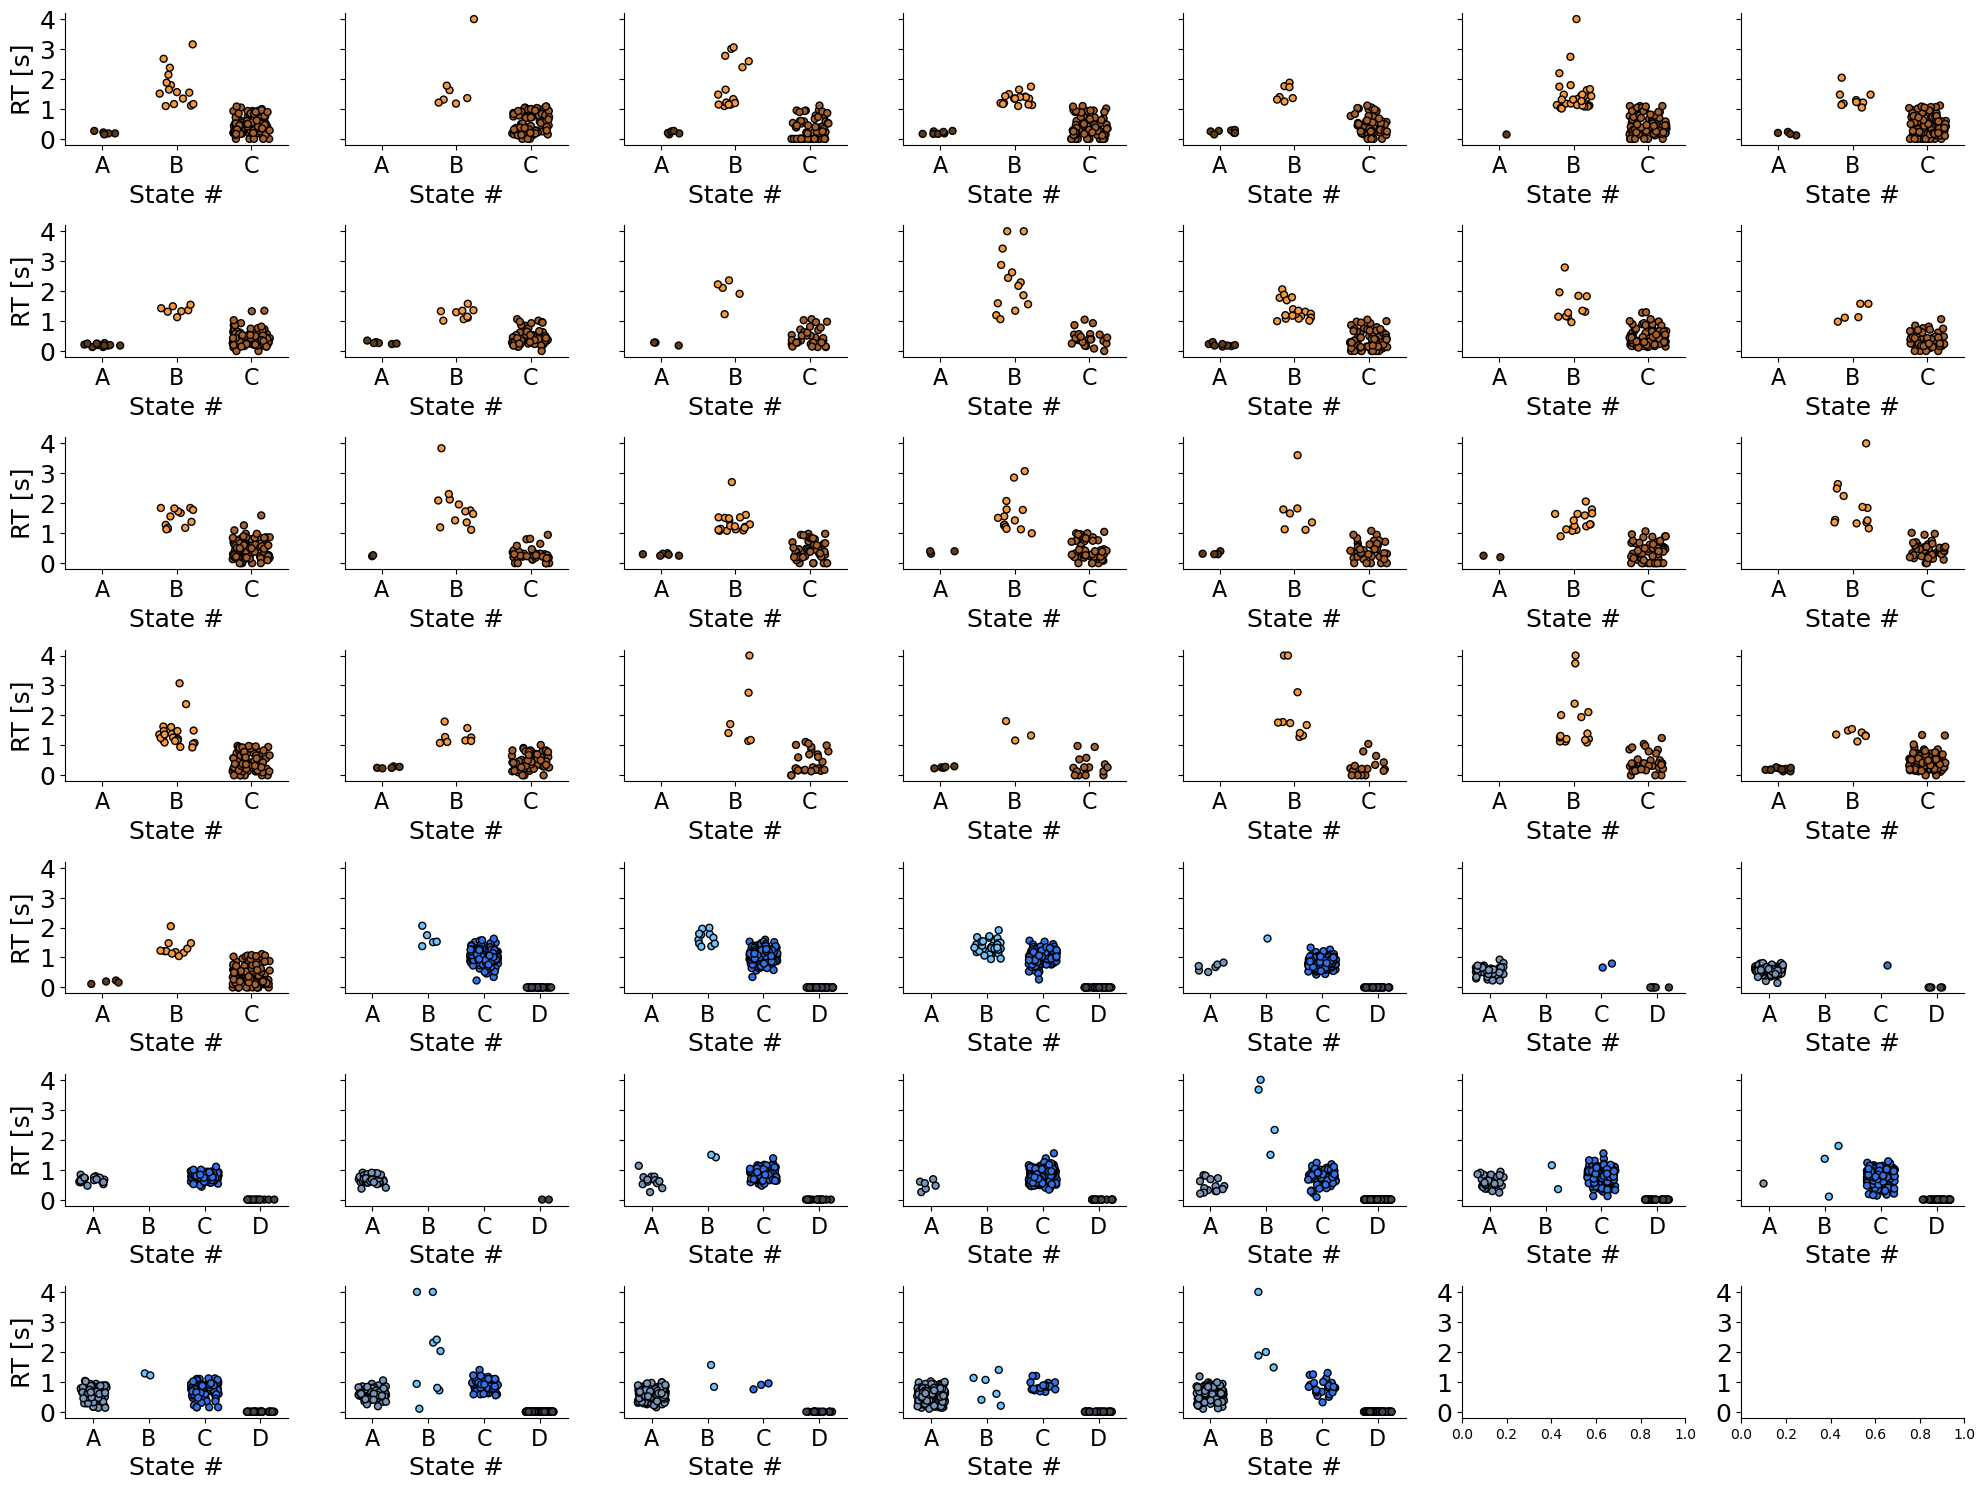

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

# New figure size, and subplot configuration
totalRows, totalCols = 7,7  
fig, ax = plt.subplots(nrows=totalRows, ncols=totalCols, figsize=(20, 15))

for axi in ax.flat:
    axi.set_ylim([-0.2, 4.2])
    axi.set_yticks(np.linspace(0,4,5), np.linspace(0,4,5).astype(int), fontsize = 18)

for ii, axi in enumerate(ax.flat[:len(perf_mouse)]): 
    emissions2 = y_test_mouse[ii][:,0].copy()
    idx_ses = butils.find_consecutive_indices(emissions2, -0.02, 0.02, 50)
    emissions = emissions2[idx_ses]
    labels = predicted_states_mouse[ii][idx_ses].copy()
    emissions_list = []
    for jj in np.arange(predicted_statesProbs_mouse[0].shape[1]):
        idx = labels == jj
        if np.sum(idx):
            emissions_list.append(emissions[idx]*4)
        else:
            emissions_list.append([-1])
    sns.stripplot(data = emissions_list, ax = axi, palette = cols_mouse, jitter = 0.25, alpha = 1, edgecolor = 'black', linewidth = 1)
    axi.set_xlabel('State #',fontsize = 18)
    axi.set_xticks(axi.get_xticks(), stat_labs[1], fontsize = 16)
    if ii in [0, 7, 14, 21, 28, 35, 42]:
        axi.set_ylabel('RT [s]', fontsize = 18)
    else:
        axi.set_yticklabels([])

counter = 0
for axi in ax.flat[len(perf_mouse):len(perf_mouse)+len(perf_macaque)]:  # Use the remaining subplots
    emissions2 = y_test_macaque[counter][:,0].copy()
    idx_ses = butils.find_consecutive_indices(emissions2, -0.02, 0.02, 50)
    emissions = emissions2[idx_ses]
    labels = predicted_states_macaque[counter][idx_ses].copy()
    emissions_list = []
    for jj in np.arange(predicted_statesProbs_macaque[0].shape[1]):
        idx = labels == jj
        if np.sum(idx):
            emissions_list.append(emissions[idx]*4)
        else:
            emissions_list.append([-1])
    sns.stripplot(data = emissions_list, ax = axi, palette = cols_macaque, jitter = 0.25, alpha = 1, edgecolor = 'black', linewidth = 1)
    axi.set_xlabel('State #', fontsize = 18)
    axi.set_xticks(axi.get_xticks(), stat_labs[0], fontsize = 16)
    if counter in [6, 13]:
        axi.set_ylabel('RT [s]', fontsize = 18)
    else:
        axi.set_yticklabels([])
    counter += 1
sns.despine()
plt.tight_layout()

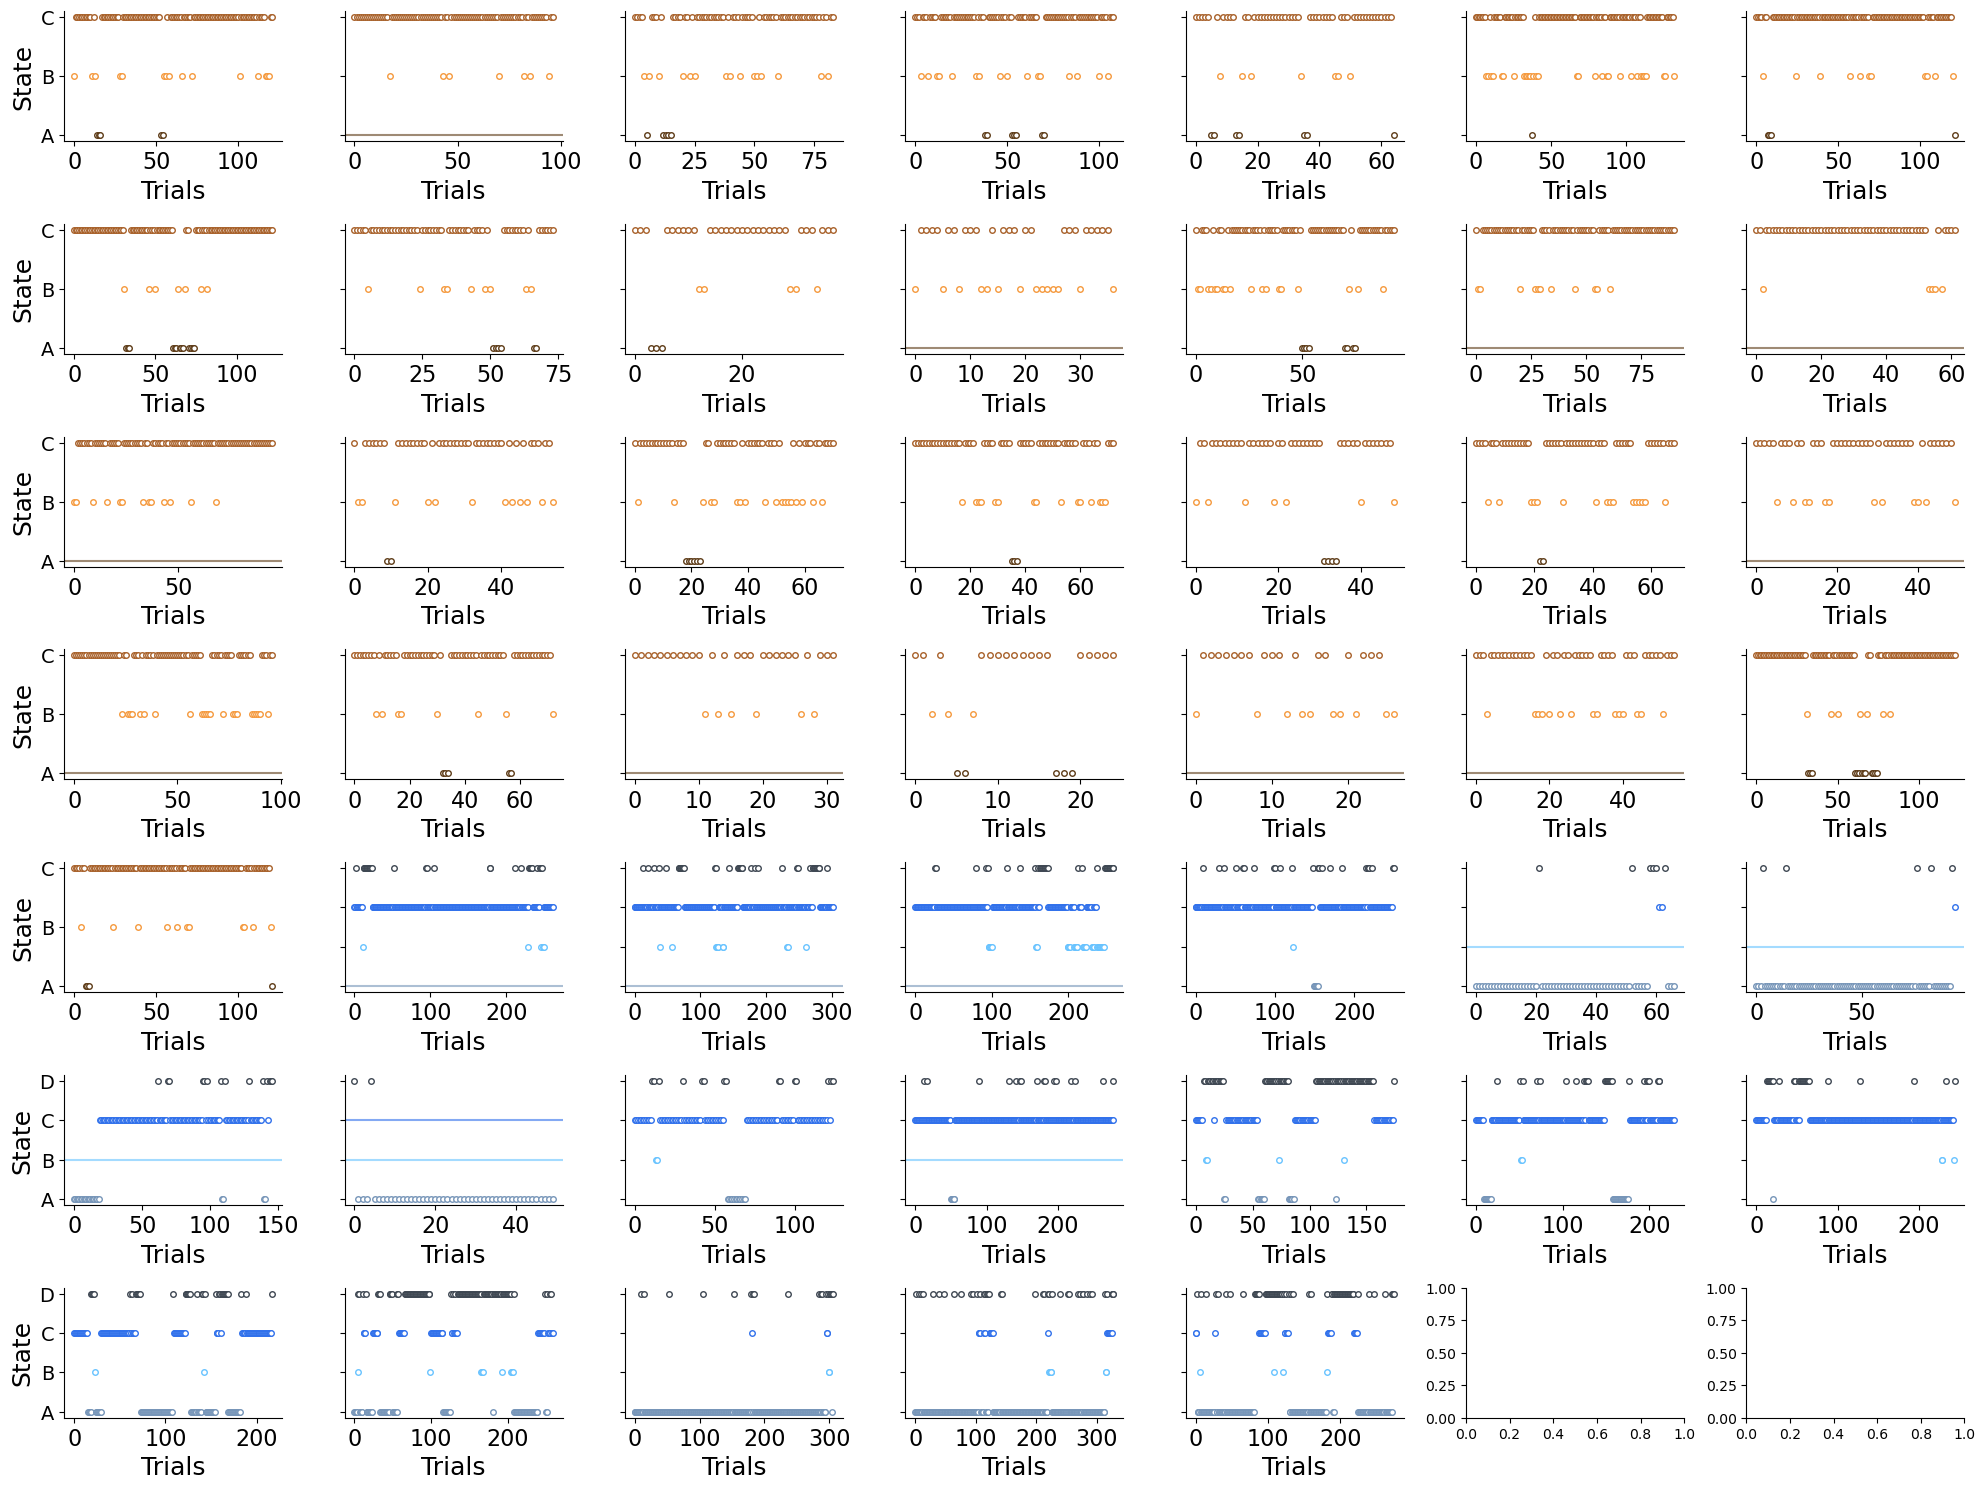

In [7]:
totalRows, totalCols = 7,7  
fig, ax = plt.subplots(nrows=totalRows, ncols=totalCols, figsize=(20, 15))

states_all = np.arange(predicted_statesProbs_mouse[0].shape[1])

for ii, axi in enumerate(ax.flat[:len(perf_mouse)]): 
    
    for jj in states_all:
        idx = predicted_states_mouse[ii] == jj
        if np.sum(idx):
            axi.plot(np.where(idx)[0], predicted_states_mouse[ii][idx], lw = 0, marker = '.', color = cols_mouse[jj], mfc = 'white', mew = 1, ms = 8)
        else:
            axi.axhline(jj, color = cols_mouse[jj], alpha = 0.6)

    axi.set_xticks(axi.get_xticks()[1:-1], axi.get_xticks()[1:-1].astype(int), fontsize = 16)
    axi.set_xlabel('Trials', fontsize = 18)
    if ii in [0, 7, 14, 21, 28, 35, 42]:
        axi.set_ylabel('State', fontsize = 18)
        axi.set_yticks(np.arange(len(stat_labs[1])), stat_labs[1], fontsize = 14)
    else:
        axi.set_yticklabels([])

counter = 0
states_all = np.arange(predicted_statesProbs_macaque[0].shape[1])

for axi in ax.flat[len(perf_mouse):len(perf_mouse)+len(perf_macaque)]:  # Use the remaining subplots
    for jj in states_all:
        idx = predicted_states_macaque[counter] == jj
        if np.sum(idx):
            axi.plot(np.where(idx)[0], predicted_states_macaque[counter][idx], lw = 0, marker = '.', color = cols_macaque[jj], mfc = 'white', mew = 1, ms = 8)
        else:
            axi.axhline(jj, color = cols_macaque[jj], alpha = 0.6)

    axi.set_xticks(axi.get_xticks()[1:-1], axi.get_xticks()[1:-1].astype(int), fontsize = 16)
    axi.set_xlabel('Trials', fontsize = 18)
    if counter in [6, 13]:
        axi.set_ylabel('State', fontsize = 18)
        axi.set_yticks(np.arange(len(stat_labs[0])), stat_labs[0], fontsize = 14)
    else:
        axi.set_yticklabels([])
    counter += 1
sns.despine()
plt.tight_layout()

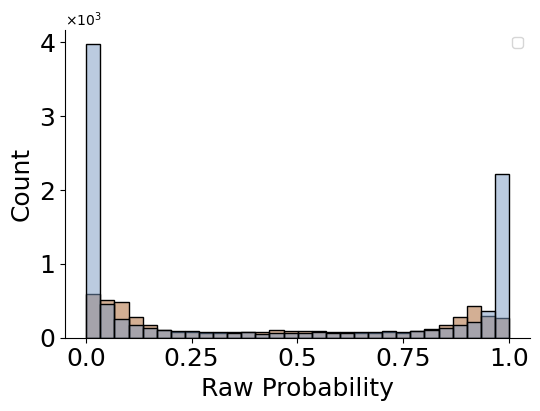

In [9]:
from matplotlib.ticker import ScalarFormatter
import seaborn as sns

class ScalarFormatterClass(ScalarFormatter):
   def _set_format(self):
      self.format = "%1.0f"

        
# Initialize an empty list to store raw probability values for all trials across all sessions
all_raw_probs_mouse = []

# Loop over all sessions to gather raw probability values
for ii in range(len(perf_mouse)):
    raw_probs_mouse = predicted_statesProbs_mouse[ii]
    all_raw_probs_mouse.extend(raw_probs_mouse.flatten())  # Flattening to pool all states and trials
    
# Initialize an empty list to store raw probability values for all trials across all sessions
all_raw_probs_macaque = []

# Loop over all sessions to gather raw probability values
for ii in range(len(perf_macaque)):
    raw_probs_macaque = predicted_statesProbs_macaque[ii]
    all_raw_probs_macaque.extend(raw_probs_macaque.flatten())  # Flattening to pool all states and trials

all_raw_probs_macaque = np.array(all_raw_probs_macaque)
all_raw_probs_mouse = np.array(all_raw_probs_mouse)

# Plot the overall distribution of raw probability values across all sessions
fig, ax = plt.subplots(figsize = (6, 4))
sns.histplot(data = [all_raw_probs_macaque[all_raw_probs_macaque>1e-3], all_raw_probs_mouse[all_raw_probs_mouse>1e-3]], palette = cus_pal, fill = True, 
             linewidth = 1, stat = 'count', edgecolor = 'black', bins = 30)

plt.xlabel('Raw Probability', fontsize=18)
plt.xticks(np.linspace(0, 1, 5), np.linspace(0, 1, 5), fontsize = 18)
plt.yticks(np.linspace(0, 4000, 5), np.linspace(0, 4000, 5).astype(int), fontsize = 18)
yScalarFormatter = ScalarFormatterClass(useMathText=True)
yScalarFormatter.set_powerlimits((3,3))
ax.yaxis.set_major_formatter(yScalarFormatter)
plt.legend()
plt.ylabel('Count', fontsize = 18)
sns.despine()

In [ ]:
def calc_kl_divergence(probs, uniform_prob):
    # Avoid log(0) by setting zero probabilities to a small near-zero value
    eps = np.finfo(float).eps
    probs_safe = np.where(probs == 0, eps, probs)
    
    # Compute the KL divergence for each trial against a uniform distribution
    kl_terms = probs_safe * np.log2(probs_safe / uniform_prob)
    
    # When P(x_i) is zero, the term should be zero
    kl_terms[np.isnan(kl_terms)] = 0
    kl_terms[np.isinf(kl_terms)] = 0
    
    kl_divergences = np.sum(kl_terms, axis=1)
    return kl_divergences


# Initialize an empty list to store KL divergences for all trials across all sessions
all_kl_divs = []

fig, ax = plt.subplots(ncols=5, nrows=4, figsize=(20, 15))
sns.despine()
timeOrder = np.concatenate([np.arange(10, len(perf_macaque), 1), np.arange(10)])

# Assuming there are 'n_states' states
n_states = predicted_statesProbs_macaque[0].shape[1]
uniform_prob = np.ones(n_states) / n_states

for ii in timeOrder:  # Loop over all sessions

    # Calculate KL divergence for this session and store
    kl_divs = calc_kl_divergence(predicted_statesProbs_macaque[ii], uniform_prob)
    all_kl_divs.extend(kl_divs)

In [ ]:
# Initialize an empty list to store KL divergences for all trials across all sessions
all_kl_divs_mouse = []

# Assuming there are 'n_states' states
n_states = predicted_statesProbs_mouse[0].shape[1]
uniform_prob = np.ones(n_states) / n_states

for ii in range(len(perf_mouse)):  # Loop over all sessions
    
    # Calculate KL divergence for this session and store
    kl_divs_mouse = calc_kl_divergence(predicted_statesProbs_mouse[ii], uniform_prob)
    all_kl_divs_mouse.extend(kl_divs_mouse)

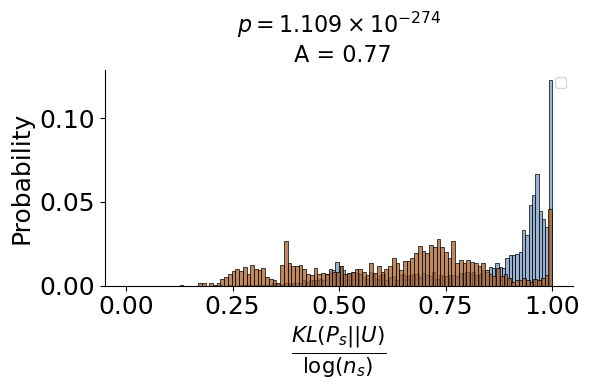

In [12]:
import scipy.stats as sts
# Plot the overall KL divergence distribution across all sessions
fig, ax = plt.subplots(figsize = (6, 4))
sns.histplot(all_kl_divs/np.log2(predicted_statesProbs_macaque[0].shape[1]), bins=100, kde=False, color = cus_pal[0], fill = True, lw = 0.5, stat = 'probability')
sns.histplot(all_kl_divs_mouse/np.log2(predicted_statesProbs_mouse[0].shape[1]), bins=100, kde=False, color = cus_pal[1], fill = True, lw = 0.5, stat = 'probability')

plt.ylabel('Probability', fontsize=18)
plt.xlim([-0.05, 1.05])
def as_si(x, ndp):
    s = '{x:0.{ndp:d}e}'.format(x=x, ndp=ndp)
    m, e = s.split('e')
    return r'{m:s}\times 10^{{{e:d}}}'.format(m=m, e=int(e))

plt.xticks(ticks = np.linspace(0., 1, 5), labels = ['{:.2f}'.format(a) for a in np.linspace(0., 1, 5)], fontsize = 18)
plt.yticks(ticks = np.linspace(0., 0.1, 3), labels = ['{:.2f}'.format(a) for a in np.linspace(0., 0.1, 3)], fontsize = 18)
plt.ylabel('Probability')
sns.despine()
plt.xlabel(r"$\frac{{KL(P_s\vert \vert U)}}{{\log(n_s)}}$", fontsize = 22)
plt.legend('')
stat, pval = sts.mannwhitneyu(all_kl_divs/np.log2(predicted_statesProbs_macaque[0].shape[1]), all_kl_divs_mouse/np.log2(predicted_statesProbs_mouse[0].shape[1]))
omega = stat/(len(all_kl_divs)*len(all_kl_divs_mouse))
plt.title(r"$p = {0:s}$".format(as_si(pval,3))+'\n A = '+str(np.round(omega, 2)), fontsize = 16)
plt.tight_layout()

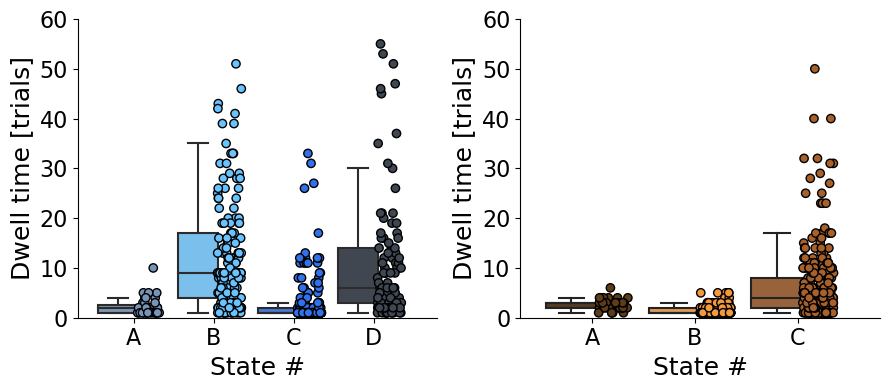

In [5]:
import pandas as pd

def rle(inarray):
    """ run length encoding. Partial credit to R rle function. 
        Multi datatype arrays catered for including non Numpy
        returns: tuple (runlengths, startpositions, values) """
    
    ia = np.asarray(inarray)                # force numpy
    n = len(ia)
    if n == 0: 
        return (None, None, None)
    else:
        y = ia[1:] != ia[:-1]               # pairwise unequal (string safe)
        i = np.append(np.where(y), n - 1)   # must include last element posi
        z = np.diff(np.append(-1, i))       # run lengths
        p = np.cumsum(np.append(0, z))[:-1] # positions
        return (z, p, ia[i])

data = []
for i in range(len(predicted_statesProbs_mouse)):
    if i < len(perf_mouse):
        z, p, ia = rle(predicted_states_mouse[i])
        for j in range(predicted_statesProbs_mouse[i].shape[1]):
            data.extend([(str(j), val) for val in z[ia == j]])

df_mouse = pd.DataFrame(data, columns=['State', 'Dwell Time'])

data = []
for i in range(len(predicted_statesProbs_macaque)):
    if i < len(perf_macaque):
        z, p, ia = rle(predicted_states_macaque[i])
        for j in range(predicted_statesProbs_macaque[i].shape[1]):
            data.extend([(str(j), val) for val in z[ia == j]])

df_macaque = pd.DataFrame(data, columns=['State', 'Dwell Time'])

fig, ax = plt.subplots(ncols = 2, figsize=(9, 4))
sns.boxplot(x='State', y='Dwell Time', data=df_macaque, palette = cols_macaque, ax=ax[0], showfliers=False, width = 0.5)
sns.stripplot(x='State', y='Dwell Time', data=df_macaque, palette=cols_macaque, ax=ax[0], size=6, alpha=1, jitter=0.15, edgecolor='black', linewidth=1)
sns.boxplot(x='State', y='Dwell Time', data=df_mouse, palette=cols_mouse, ax=ax[1], showfliers=False, width = 0.5)
sns.stripplot(x='State', y='Dwell Time', data=df_mouse, palette=cols_mouse, ax=ax[1], size=6, alpha=1, jitter=0.15, edgecolor='black', linewidth=1)

for axi in ax:
    axi.set_ylabel('Dwell time [trials]', fontsize=18)
    axi.set_xlabel('State #', fontsize = 18)
ax[0].set_ylim([0, 60])
ax[0].set_yticks(np.linspace(0, 60, 7), np.linspace(0, 60, 7).astype(int), fontsize = 16)

ax[1].set_ylim([0, 60])
ax[1].set_yticks(np.linspace(0, 60, 7), np.linspace(0, 60, 7).astype(int), fontsize = 16)

num_states = predicted_statesProbs_macaque[0].shape[1]
ax[0].set_xticks(np.arange(num_states)+0.2, stat_labs[0], fontsize = 16)
ax[0].set_xlim([-0.5, num_states])
num_states = predicted_statesProbs_mouse[0].shape[1]
ax[1].set_xticks(np.arange(num_states)+0.2, stat_labs[1], fontsize = 16)
ax[1].set_xlim([-0.5, num_states])
for axi in ax:
    for line in axi.collections:
        x, y = line.get_offsets().T
        line.set_offsets(np.c_[x + 0.4, y])
plt.tight_layout()
sns.despine()

In [8]:
#target distance
def get_td (paths,distance,offset,boxsize):
    ntrls=len(paths)
    td=np.empty(ntrls)
    for itrl, trl in enumerate(paths):

        x_near_targ=np.where(abs(trl[:,0]-distance[itrl])==np.min(abs(trl[:,0]-distance[itrl])))[0][0]

        y_player=trl[x_near_targ][1] 

        y_target=offset[itrl]

        inner_edge=(abs(y_target)-boxsize/2)*np.sign(y_target)
        outer_edge=(abs(y_target)+boxsize/2)*np.sign(y_target)

        if np.sign(y_target)==np.sign(y_player) and abs(inner_edge)<=abs(y_player)<=abs(outer_edge):
            td[itrl]=0
        else:
            td[itrl]=abs((inner_edge - y_player)/((abs(y_target)-boxsize/2)*2))

    return td

def get_mean_speed(paths): 
    all_speed=np.empty(len(paths),dtype=object)
    for trn in range (len(paths)):
        all_speed[trn]=np.zeros(len(paths[trn])) 
        for tick in range(len(paths[trn])-1):
            all_speed[trn][tick]=np.linalg.norm(paths[trn][tick+1]-paths[trn][tick])/(1/60)

    mean_speed=np.empty(len(paths))

    for itrl, trl in enumerate(all_speed):
        
        mean_speed [itrl] = np.mean(trl)

    return mean_speed 


def euclidean_distance(point1, point2):
    return np.sqrt(np.sum((np.array(point1) - np.array(point2))**2))

def get_path_length(paths, distance, rts):
    length = np.zeros(len(paths), dtype=object)

    for itr, tr in enumerate(paths):
        tr_length = 0
        for i in range(rts[itr], len(tr) - 1):
            if tr[i + 1][0] <= distance[itr]:  # Check if the x-coordinate of the next point is less than or equal to distance to stimuli
                tr_length += euclidean_distance(tr[i], tr[i + 1])
            else:
                break  # Stop calculating the path length when the next point's x-coordinate exceeds distance to stimuli
        length[itr] = tr_length

    return length

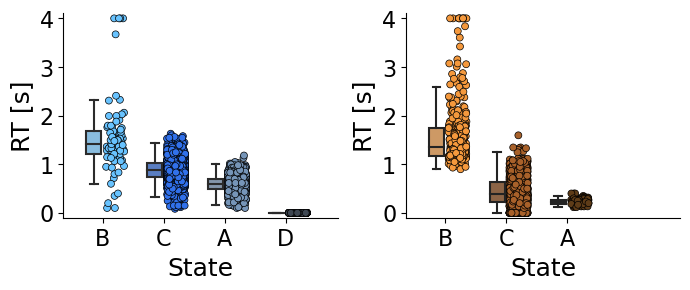

In [3]:
import pandas as pd
import numpy as np
fig, ax = plt.subplots(ncols = 2, figsize=(7,3))
sns.despine()

cols_macaque_dark = [sns.desaturate(col,0.75) for col in cols_macaque]

emissions_all = []
labels_all = []

# loop over all macaque performance measurements
for ii in range(len(perf_macaque)):
    emissions2 = y_test_macaque[ii][:,0].copy()
    idx_ses = butils.find_consecutive_indices(emissions2, -0.02, 0.02, 50)
    emissions = emissions2[idx_ses]
    labels = predicted_states_macaque[ii].copy()[idx_ses].copy()

    emissions_all.append(emissions*4)
    labels_all.append(labels)

# convert list of arrays to single array
emissions_all = np.concatenate(emissions_all)
labels_all = np.concatenate(labels_all)

# create a DataFrame from the data
data_all_macaque = pd.DataFrame({
    'RT': emissions_all,
    'State': labels_all
})


import seaborn as sns
import matplotlib.pyplot as plt

def reorder_states(data, state_col, value_col):
    # Calculate the median 'RT' for each state.
    state_order = data.groupby(state_col)[value_col].median().reset_index()

    # Add a 'StateOrder' column that indicates the order of states based on the median 'RT'.
    state_order["StateOrder"] = state_order[value_col].rank(ascending=False)

    # Merge the original DataFrame with the 'state_order' DataFrame.
    data = pd.merge(data, state_order[[state_col, "StateOrder"]], on=state_col)

    return data, state_order

# Apply the function to your DataFrames
data_all_macaque, state_order_macaque = reorder_states(data_all_macaque, 'State', 'RT')

cols_macaque2 = np.array(cols_macaque)[state_order_macaque.sort_values("StateOrder")["State"].values.astype(int)]
cols_macaque_dark2 = np.array(cols_macaque_dark)[state_order_macaque.sort_values("StateOrder")["State"].values.astype(int)]


# Repeat the same for the second subplot
cols_mouse_dark = [sns.desaturate(col,0.75) for col in cols_mouse]
emissions_all = []
labels_all = []

# loop over all mouse performance measurements
for ii in range(len(perf_mouse)):
    emissions2 = y_test_mouse[ii][:,0].copy()
    idx_ses = butils.find_consecutive_indices(emissions2, -0.02, 0.02, 50)
    emissions = emissions2[idx_ses].copy()
    labels = predicted_states_mouse[ii][idx_ses].copy()

    emissions_all.append(emissions*4)
    labels_all.append(labels)

# convert list of arrays to single array
emissions_all = np.concatenate(emissions_all)
labels_all = np.concatenate(labels_all)

# create a DataFrame from the data
data_all_mouse = pd.DataFrame({
    'RT': emissions_all,
    'State': labels_all
})

data_all_mouse, state_order_mouse = reorder_states(data_all_mouse, 'State', 'RT')
cols_mouse_dark2 = np.array(cols_mouse_dark)[state_order_mouse.sort_values("StateOrder")["State"].values.astype(int)]
cols_mouse2 = np.array(cols_mouse)[state_order_mouse.sort_values("StateOrder")["State"].values.astype(int)]


# Now plot the data using the 'StateOrder' column for ordering
sns.boxplot(x='StateOrder', y='RT', data=data_all_mouse, palette=cols_mouse_dark2, ax=ax[1], showfliers = False, linewidth = 1.5, width=0.25)
sns.boxplot(x='StateOrder', y='RT', data=data_all_macaque, palette=cols_macaque_dark2, ax=ax[0], showfliers = False, linewidth = 1.5, width=0.25)

sns.stripplot(x='StateOrder', y='RT', data=data_all_macaque, palette=cols_macaque2, jitter=0.15, alpha=1, edgecolor='black', linewidth=0.5, ax=ax[0], zorder = 1, dodge=False)

ax[0].set_xlim(ax[0].get_xlim()[0], ax[0].get_xlim()[1] + 0.5)
# shift the stripplot to the right
for line in ax[0].collections:
    x, y = line.get_offsets().T
    line.set_offsets(np.c_[x + 0.35, y])

sns.stripplot(x='StateOrder', y='RT', data=data_all_mouse, palette=cols_mouse2, jitter=0.15, alpha=1, edgecolor='black', linewidth=0.5, ax=ax[1], zorder = 0, dodge=False)

for line in ax[1].collections:
    x, y = line.get_offsets().T
    line.set_offsets(np.c_[x + 0.35, y])

for ii in range(2):
    ax[ii].set_ylim([-0.1, 4.1])
    ax[ii].set_ylabel('RT [s]', fontsize = 18)
    ax[ii].set_xlabel('State', fontsize = 18)
    ax[ii].set_yticks(np.linspace(0, 4, 5), np.linspace(0, 4, 5).astype(int), fontsize = 16)
    ax[ii].set_xlim(-0.5, 4)

ax[0].set_xticks(np.arange(predicted_statesProbs_macaque[0].shape[1]) + 0.15, np.arange(predicted_statesProbs_macaque[0].shape[1]), fontsize = 16)
ax[1].set_xticks(np.arange(predicted_statesProbs_mouse[0].shape[1]) + 0.15, np.arange(predicted_statesProbs_mouse[0].shape[1]), fontsize = 16)

ax[0].set_xticklabels(np.array(stat_labs[0])[state_order_macaque.sort_values("StateOrder")["State"].values.astype(int)])
ax[1].set_xticklabels(np.array(stat_labs[1])[state_order_mouse.sort_values("StateOrder")["State"].values.astype(int)])
plt.tight_layout()
#plt.savefig('Results/BothSpecies_Emissions_27022024.svg', transparent = True)

In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import numpy as np
from sklearn.model_selection import StratifiedKFold
import os
import pandas as pd

dec_list_macaque, rt_list_macaque = [], []
for ii in range(18):
    dats_behav = np.load('RawData/Macaque/Decisions_RT_macaque_session'+str(ii)+'.npz', allow_pickle = True)
    dec_list_macaque.append(dats_behav['decisions'])
    rt_list_macaque.append(dats_behav['RT'])

dec_list_mouse, rt_list_mouse = [], []
for ii in range(29):
    dats_behav = np.load('RawData/Mouse/Decisions_RT_mouse_session'+str(ii)+'.npz', allow_pickle = True)
    dec_list_mouse.append(dats_behav['decisions'])
    rt_list_mouse.append(dats_behav['RT'])

# Create a StratifiedKFold object
kfold = StratifiedKFold(n_splits = 20)
def logistic_regression_cv(input_matrix, categorical_matrix, cv_scheme, numShuf = 200):
    # Define logistic regression model with L2 penalty
    logistic = LogisticRegression(max_iter=int(1e6), class_weight = 'balanced')

    # Define hyperparameter search space for cross-validation
    hyperparameters = {'C': np.logspace(-4, 4, 20)}

    # Define grid search cross-validation
    clf = GridSearchCV(logistic, hyperparameters, cv=cv_scheme, scoring='f1_weighted', n_jobs = os.cpu_count()-2)

    y = categorical_matrix.reshape(-1,).copy()
    # Fit model
    clf.fit(input_matrix, y)

    # Get optimal weights (coefficients)
    weights = clf.best_estimator_.coef_

    # Get mean cross-validation score
    mean_cv_score = clf.best_score_
    
    cv_Sh = np.zeros(numShuf)
    for s in range(numShuf):
        cv_Sh[s] = metrics.f1_score(y, np.random.permutation(y), average = 'weighted')
    return weights, mean_cv_score, cv_Sh

# Concatenate all input matrices and categorical matrices
input_matrix_macaque = np.concatenate([d.reshape(-1, 1) for d in rt_list_macaque], axis=0)

categorical_matrix_macaque = np.concatenate([d.reshape(-1, 1) for d in dec_list_macaque], axis=0)
categorical_matrix_macaque[(categorical_matrix_macaque == 0)|(categorical_matrix_macaque > 3)] = 3
categorical_matrix_macaque-=1
# Train a single model on all data
weights_LR_macaque, scors_macaque, scors_macaque_Sh = logistic_regression_cv(input_matrix_macaque, categorical_matrix_macaque, kfold)

# Concatenate all input matrices and categorical matrices
input_matrix_mouse = np.concatenate([d.reshape(-1, 1) for d in rt_list_mouse], axis=0)
categorical_matrix_mouse = np.concatenate([d.reshape(-1, 1) for d in dec_list_mouse], axis=0)
categorical_matrix_mouse-=1
categorical_matrix_mouse[categorical_matrix_mouse == 3] = 2

# Train a single model on mouse data
weights_LR_mouse, scors_mouse, scors_mouse_Sh = logistic_regression_cv(input_matrix_mouse, categorical_matrix_mouse, kfold)

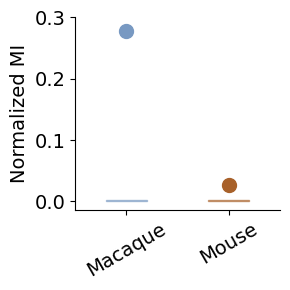

In [5]:
fig, ax = plt.subplots(ncols=1, figsize=(3, 3))
cus_pal = sns.color_palette(['#7899c2ff', '#A8612A'])

for ii, scor, scor_Sh in zip(range(2), [scors_macaque, scors_mouse], [scors_macaque_Sh, scors_mouse_Sh]):
    rect = plt.Rectangle(xy=(ii-0.2, np.nanpercentile(scor_Sh, 1)), width=0.4, 
                         height=np.nanpercentile(scor_Sh, 99) - np.nanpercentile(scor_Sh, 1),
                         alpha=0.6, color=cus_pal[ii])
    ax.add_patch(rect)
    ax.scatter([ii], scor, s=100, color=cus_pal[ii])

plt.xlim(-0.5, 1.5) 
plt.xticks(np.arange(2), ['Macaque', 'Mouse'], fontsize = 14, rotation = 30)
plt.yticks(np.linspace(0, 0.3, 4), np.linspace(0, 0.3, 4).astype(np.float32), fontsize = 14)
plt.ylabel('Normalized MI', fontsize = 14)
sns.despine()
plt.tight_layout()

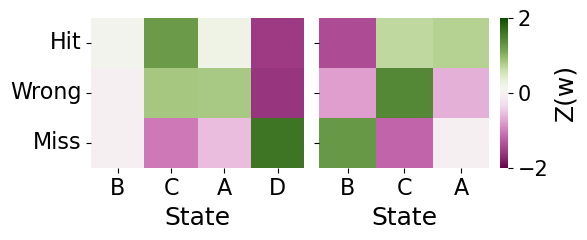

In [6]:
import cmcrameri as cmc
import scipy.stats as sts
fig, ax = plt.subplots(ncols=2, figsize=(6,2.5))
titles = ['Macaque', 'Mouse']
outcomes = ['Hit', 'Wrong', 'Miss']
num_states = [weights_LR_macaque.shape[1], weights_LR_mouse.shape[1]]
stateOrder_macaque = state_order_macaque.sort_values("StateOrder")["State"].values.astype(int)
stateOrder_mouse = state_order_mouse.sort_values("StateOrder")["State"].values.astype(int)

sns.heatmap(sts.zscore(weights_LR_macaque[:,stateOrder_macaque],axis = 1), cmap = 'cmc.bam', vmin = -2, vmax = 2, ax = ax[0], cbar = False)
heatmap = sns.heatmap(sts.zscore(weights_LR_mouse[:,stateOrder_mouse], axis = 1), cmap = 'cmc.bam', vmin = -2, vmax = 2, ax = ax[1], cbar_kws={'label':'Z(w)'})

for ii, axi in enumerate(ax):
    axi.set_yticks(np.arange(len(outcomes))+0.5)
    axi.set_xticks(np.arange(num_states[ii])+0.5)
    if ii:
        axi.set_xticklabels(stat_labs[ii][stateOrder_mouse], rotation = 0, fontsize = 16)
    else:
        axi.set_xticklabels(stat_labs[ii][stateOrder_macaque], rotation = 0, fontsize = 16)
    axi.set_xlabel('State', fontsize = 18)

ax[0].set_yticklabels(outcomes, fontsize = 16, rotation = 0)
ax[1].set_yticklabels([])
heatmap.figure.axes[-1].yaxis.label.set_size(18)
cbar = ax[1].collections[0].colorbar
cbar.ax.tick_params(labelsize=15)
plt.tight_layout()

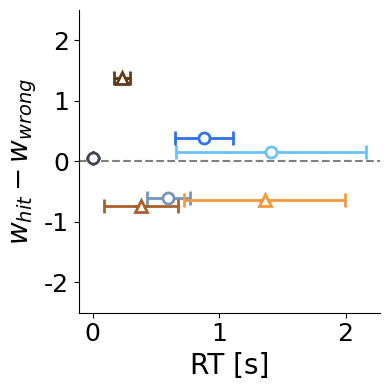

In [7]:
import pandas as pd
def darken_color(color, amount=0.5):
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], max(0, min(1, amount * c[1])), c[2])


fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))
ws = sts.zscore(weights_LR_macaque, axis = 1)
#ws = weights_LR_macaque.copy()
for ii, state in enumerate(stateOrder_macaque):
    subset = data_all_macaque[data_all_macaque['State'] == state]
    centroid_x = subset['RT'].median()
    centroid_y = ws[0,state] - ws[1,state]
    std_x = subset['RT'].std()
    std_y = 0
    _, caps, _ = plt.errorbar(x = centroid_x, y = centroid_y, xerr=std_x, yerr=std_y, fmt='o', markersize=8, linewidth=2, color = cols_macaque[state], 
                            capsize = 5, label = 'State '+stat_labs[0][state], markerfacecolor = 'white', mew = 2)
    for cap in caps:
        cap.set_markeredgewidth(2)

ws = sts.zscore(weights_LR_mouse, axis = 1)
#ws = weights_LR_mouse.copy()
for ii, state in enumerate(stateOrder_mouse):

    subset = data_all_mouse[data_all_mouse['State'] == state]
    centroid_x = subset['RT'].median()
    centroid_y = ws[0,state] - ws[1,state]
    std_x = subset['RT'].std()
    std_y = 0
    _, caps, _ = plt.errorbar(x = centroid_x, y = centroid_y, xerr=std_x, yerr=std_y, fmt='^', markersize=8, linewidth=2, color = cols_mouse[state], 
                            capsize = 5, label = 'State '+stat_labs[1][state], markerfacecolor = 'white', mew = 2)
    for cap in caps:
        cap.set_markeredgewidth(2)


axes.set_yticks(np.linspace(-2, 2, 5), np.linspace(-2, 2, 5).astype(int), fontsize = 18)
axes.set_ylim([-2.5, 2.5])
axes.set_xticks(np.linspace(0, 2, 3), np.linspace(0, 2, 3).astype(int), fontsize = 18)
axes.axhline(0, ls = '--', color = 'gray')
axes.set_xlabel('RT [s]', fontsize = 20)
axes.set_ylabel(r'$w_{hit} - w_{wrong}$', fontsize = 20)

plt.tight_layout()
sns.despine()

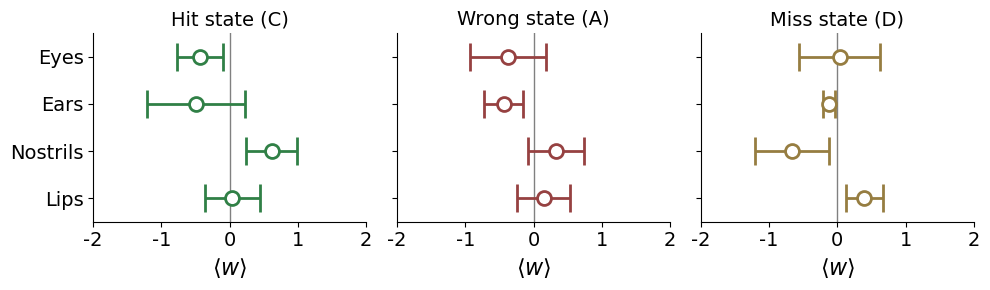

In [9]:
titles = ['Hit state (C)', 'Wrong state (A)', 'Miss state (D)']
cols_outc = ['#308046', '#964141', '#967d41']
#states = [[2, 0, 3], [2, 0, 1]]
states = [[2, 0, 3], [0, 2, 1]]

categories = ['Eyes', 'Ears', 'Nostrils', 'Lips']
y_positions = np.arange(len(categories))  # Y positions for each category
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.stats as sts

# Assuming weights_macaque, states, cols_outc, and y_positions are defined

fig, axes = plt.subplots(1, 3, figsize=(10, 3))
sns.despine()

for i, ax in enumerate(axes.flatten()):
    reduc_weights = np.zeros(4)
    reduc_std = np.zeros(4) # For storing the standard deviations
    wts = sts.zscore(np.array(weights_macaque[0])[states[0][i], 0, :], axis=-1)

    # Define the indices for each group
    indices = [np.concatenate([np.arange(4), np.arange(8, 11)]), 
               np.arange(4, 8), 
               [11, 12], 
               np.arange(-4, 0)]

    # Compute mean and standard deviation for each group
    for j in range(4):
        group_wts = wts[indices[j]]
        reduc_weights[j] = np.mean(group_wts)
        reduc_std[j] = np.std(group_wts)/np.sqrt(group_wts.shape[0])

    # Plotting the error bars
    for j, y_pos in enumerate(y_positions):
        ax.errorbar(reduc_weights[j], y_pos, xerr=reduc_std[j], fmt='o', color=cols_outc[i], 
                    zorder=3, capsize=10, ms=10, lw = 2, mfc = 'white', capthick = 2, mew = 2)

    ax.axvline(x=0, color='grey', lw=1, zorder=1)

    ax.set_yticks(y_positions)
    ax.set_yticklabels(categories[::-1], fontsize=14)
    if i:
        ax.set_yticklabels([])
    ax.set_xticks(np.linspace(-2, 2, 5), np.linspace(-2, 2, 5).astype(int), fontsize=14)
    ax.set_xlim(-2, 2)
    ax.set_ylim(-0.5, 3.5)
    ax.set_xlabel(r"$\langle w \rangle$", fontsize=16)
    ax.set_title(titles[i], fontsize=14)

plt.tight_layout()

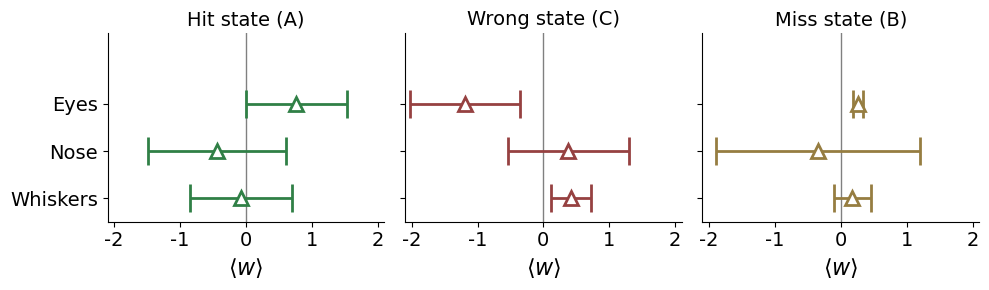

In [27]:
categories = ['Eyes', 'Nose', 'Whiskers']
titles = ['Hit state (A)', 'Wrong state (C)', 'Miss state (B)']

y_positions = np.arange(len(categories))  # Y positions for each category

fig, axes = plt.subplots(1, 3, figsize=(10, 3))
sns.despine()

for i, ax in enumerate(axes.flatten()):
    reduc_weights = np.zeros(3)
    reduc_std = np.zeros(3)  # For storing the standard deviations
    wts = sts.zscore(np.array(weights_mouse[0])[states[1][i], 0, :], axis=-1)

    # Define the indices for each group
    indices = [[0, 2, 3], [1, 4, 5], np.arange(-2, 0)]

    # Compute mean and standard deviation for each group
    for j in range(3):
        group_wts = wts[indices[j]]
        reduc_weights[j] = np.mean(group_wts)
        reduc_std[j] = np.std(group_wts)

    # Plotting the error bars with modified cap width
    for j, y_pos in enumerate(y_positions):
        ax.errorbar(reduc_weights[j], y_pos, xerr=reduc_std[j], fmt='^', color=cols_outc[i], 
                    zorder=3, capsize=10, ms=10, lw = 2, mfc = 'white', capthick = 2, mew = 2)

    ax.axvline(x=0, color='grey', lw=1, zorder=1)

    ax.set_yticks(y_positions)
    ax.set_yticklabels(categories[::-1], fontsize=14)
    if i:
        ax.set_yticklabels([])
    ax.set_xticks(np.linspace(-2, 2, 5), np.linspace(-2, 2, 5).astype(int), fontsize=14)
    ax.set_xlim(-2.1, 2.1)
    ax.set_ylim(-0.5, 3.5)
    ax.set_xlabel(r"$\langle w \rangle$", fontsize=16)
    ax.set_title(titles[i], fontsize=14)

plt.tight_layout()

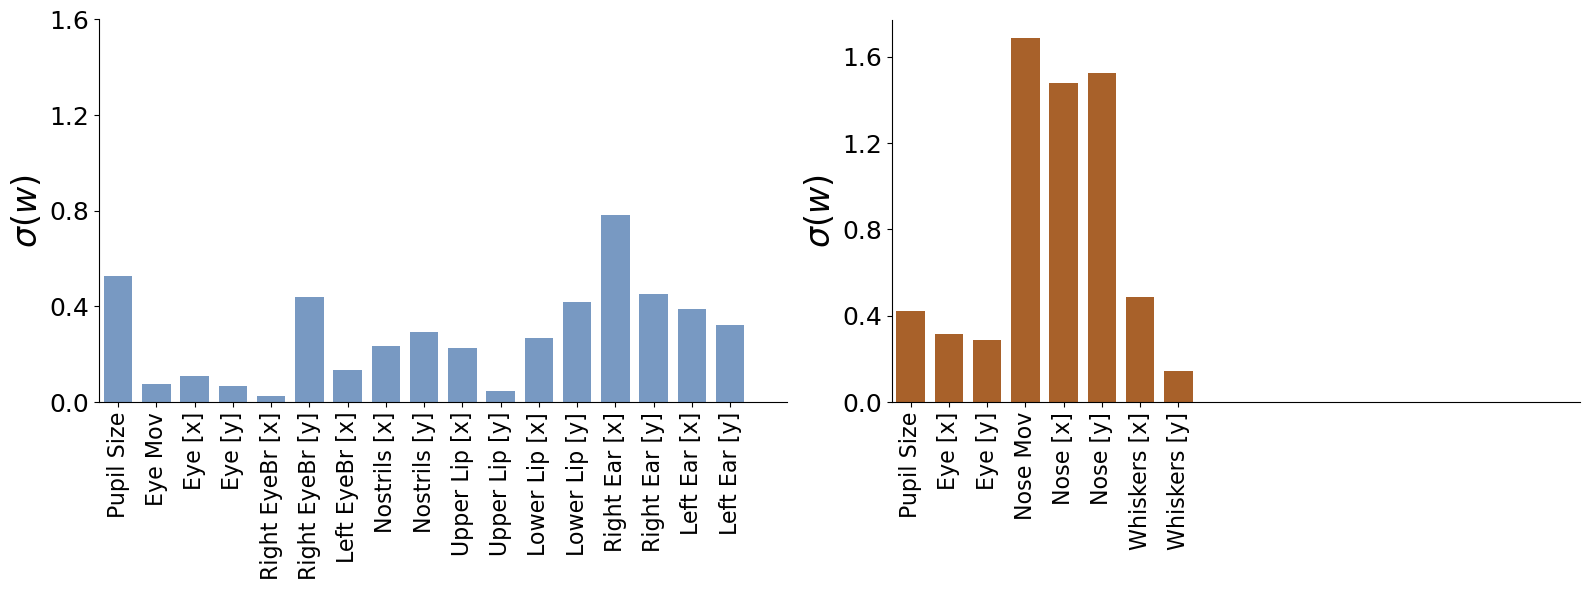

In [24]:
fig, ax = plt.subplots(ncols = 2, figsize = (16, 6))
cus_pal = sns.color_palette(['#7899c2ff', '#A8612A'])
all_vars_macaque  = np.array(['Pupil Size', 'Eye Mov', 'Eye [x]', 'Eye [y]', 'Right Ear [x]', 'Right Ear [y]', 'Left Ear [x]', 'Left Ear [y]', 'Right EyeBr [x]', 'Right EyeBr [y]', 'Left EyeBr [x]', 
                    'Nostrils [x]', 'Nostrils [y]', 'Upper Lip [x]', 'Upper Lip [y]', 'Lower Lip [x]', 'Lower Lip [y]'])[newOrder_macaque]
ax[0].bar(x = all_vars_macaque, height = np.std(np.array(weights_macaque[0][:,0,newOrder_macaque]), axis = 0), color = cus_pal[0], width = 0.75)
ax[1].bar(x = np.array(selected_variables_mouse)[newOrder_mouse], height = np.std(np.array(weights_mouse[0][:,0,newOrder_mouse]), axis = 0), color = cus_pal[1], width = 0.75)

for axi in ax:
    axi.set_xlim(-0.5, len(all_vars_macaque)+0.5)
    #axi.set_xlim(0, 0.2)
    axi.set_yticks(np.linspace(0, 1.6, 5), np.linspace(0, 1.6, 5).astype(np.float32), fontsize = 18)
    axi.set_xticks(axi.get_xticks(), axi.get_xticklabels(), fontsize = 16, rotation = 90)
    axi.set_ylabel('$\sigma(w)$', fontsize = 24)
sns.despine()
plt.tight_layout()

In [25]:
from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D


def radar_factory(num_vars, frame='circle'):
    """Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle' | 'polygon'}
        Shape of frame surrounding axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)
    
    class RadarTransform(PolarAxes.PolarTransform):
        def transform_path_non_affine(self, path):
            # Paths with non-unit interpolation steps correspond to gridlines,
            # in which case we force interpolation (to defeat PolarTransform's
            # autoconversion to circular arcs).
            if path._interpolation_steps > 1:
                path = path.interpolated(num_vars)
            return Path(self.transform(path.vertices), path.codes)

    class RadarAxes(PolarAxes):

        name = 'radar'
        
        PolarTransform = RadarTransform

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.concatenate((x, [x[0]]))
                y = np.concatenate((y, [y[0]]))
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=0.5, edgecolor="k")
            else:
                raise ValueError("unknown value for 'frame': %s" % frame)

        def draw(self, renderer):
            """ Draw. If frame is polygon, make gridlines polygon-shaped """
            if frame == 'polygon':
                gridlines = self.yaxis.get_gridlines()
                for gl in gridlines:
                    gl.get_path()._interpolation_steps = num_vars
            super().draw(renderer)


        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)


                return {'polar': spine}
            else:
                raise ValueError("unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta


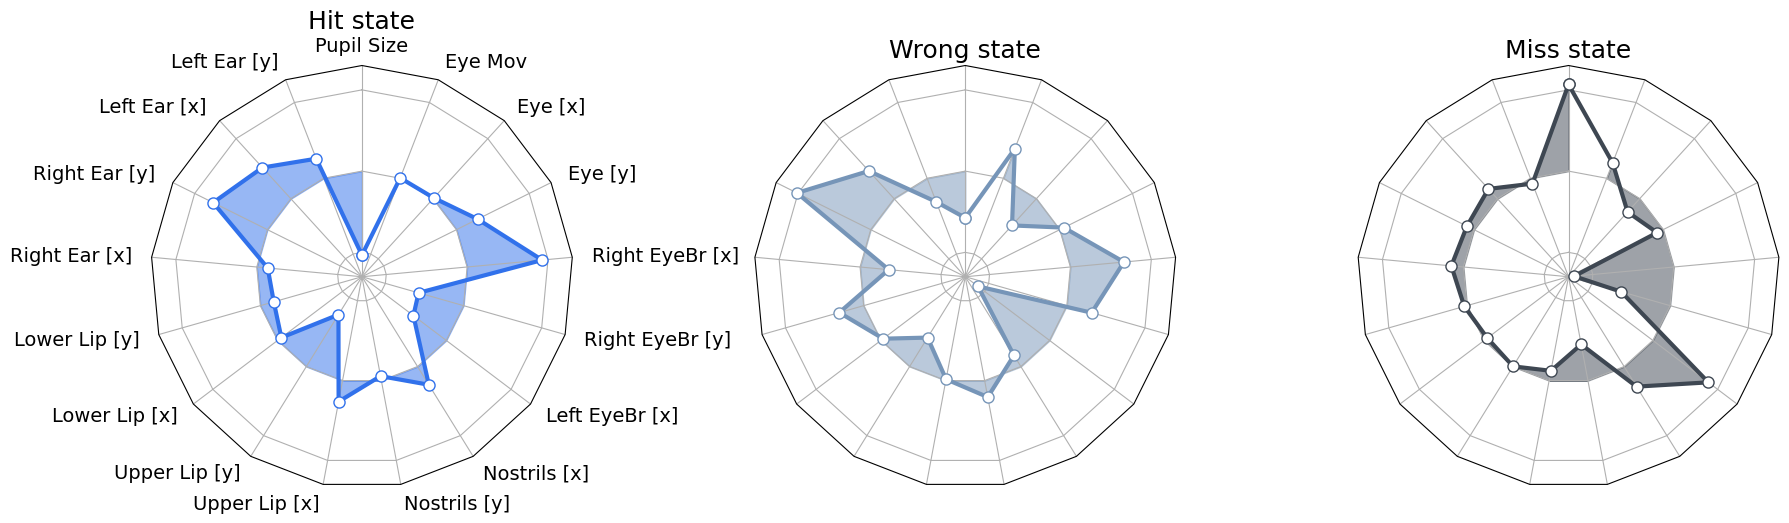

In [10]:
from scipy.stats import zscore as zs

# Adjusted states indices
newStats_macaque = state_order_macaque.sort_values("StateOrder")["State"].values
newStats_mouse = state_order_mouse.sort_values("StateOrder")["State"].values

states = [[2,0,3], [5,4,3]]
variables = [np.array(all_vars_macaque)[newOrder_macaque], selected_variables_mouse]
cols_outc = ['#308046', '#964141', '#967d41']
titles = ['Hit state', 'Wrong state', 'Miss state']

spoke_labels = np.concatenate([[np.array(all_vars_macaque)[newOrder_macaque][0]], np.array(all_vars_macaque)[newOrder_macaque][1:][::-1]])

N = len(spoke_labels)
theta = radar_factory(N, frame='polygon')
weights = [weights_macaque[0], weights_mouse[0]]
colors = [cols_macaque, cols_mouse]
colors = [cols_macaque_dark, cols_mouse]
num_plots = len(states[0])  # assuming all states have the same length
num_cols = 3  # set number of columns
num_rows = num_plots // num_cols if num_plots % num_cols == 0 else num_plots // num_cols + 1

fig, axes = plt.subplots(num_rows, num_cols, figsize=(6*num_cols, 6*num_rows), subplot_kw=dict(projection='radar'))
fig.subplots_adjust(hspace=0.4, wspace=0.7, top=0.85, bottom=0.05)
axes = axes.flatten()  # flatten the axes array if more than 1 subplot

for i, ax in enumerate(axes):
    ax.set_rgrids([-0.35, 0.0, 0.35])
    if i < len(weights_macaque[0]):  # to avoid indexing error
        case_data = zs(np.array(weights_macaque[0])[states[0][i],0,:][newOrder_macaque], axis = -1)
        line = ax.plot(theta, case_data, lw=3, color=cols_macaque[states[0][i]], marker = 'o', ms = 8, mfc = 'white')
        
        # create zero baseline polygon
        baseline = np.zeros_like(case_data)
        ax.fill_between(theta, baseline, case_data, alpha=0.5, color=cols_macaque[states[0][i]])  # color for each weight
        
        ax.set_varlabels(spoke_labels)
        ax.set_xticklabels(spoke_labels, fontsize=14)
        ax.set_yticklabels([])
        ax.set_rlim([-2.6, 2.6])
        ax.set_rticks(np.linspace(-2,2,3))
        # Rotate labels
        for label, angle in zip(ax.get_xticklabels(), theta):
            if angle in (0, np.pi):
                label.set_horizontalalignment('center')
            elif 0 < angle < np.pi:
                label.set_horizontalalignment('right')
            else:
                label.set_horizontalalignment('left')
        ax.set_title(titles[i], fontsize = 18)
        if i:
            ax.set_xticklabels([])
    else:
        ax.remove()  # remove the extra subplots
plt.tight_layout()

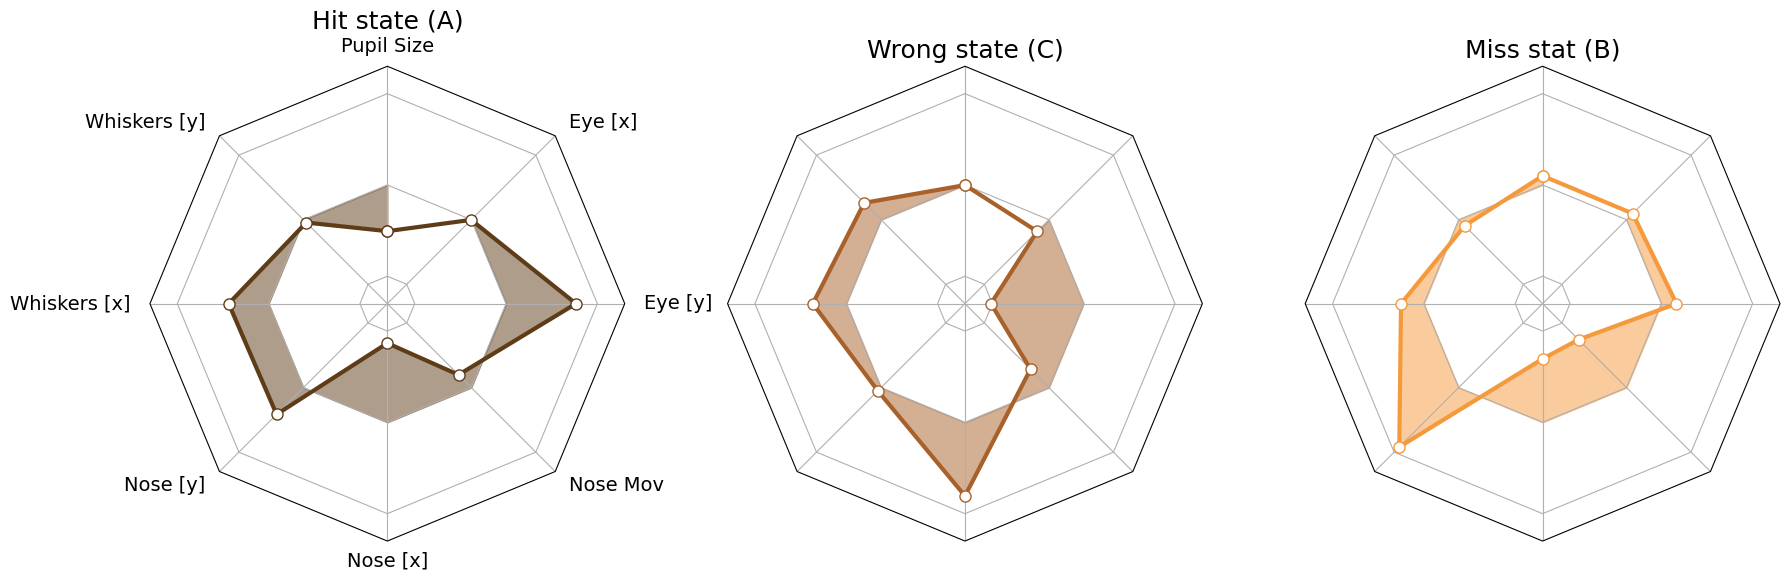

In [28]:
from scipy.stats import zscore as zs


# Adjusted states indices
states = [[5,1,6], [5,4,3]]
states = [[4,3,6], [2,0,1]]
states = [[4,3,6], [0,2,1]]
#states = [states_macaque, states_mouse]

variables = [all_vars_macaque, selected_variables_mouse]
cols_outc = ['#308046', '#964141', '#967d41']
titles = ['Hit state (A)', 'Wrong state (C)', 'Miss stat (B)']

selected_variables_mouse = ['Pupil Size', 'Nose Mov', 'Eye [x]', 'Eye [y]', 'Nose [x]', 'Nose [y]', 'Whiskers [x]', 'Whiskers [y]']
newOrder_mouse = np.array([0, 2, 3, 1, 4, 5, 6, 7])

spoke_labels = np.concatenate([[np.array(selected_variables_mouse)[newOrder_mouse][0]], np.array(selected_variables_mouse)[newOrder_mouse][1:][::-1]])

N = len(spoke_labels)
theta = radar_factory(N, frame='polygon')
weights = [weights_macaque[0], weights_mouse[0]]

num_plots = len(states[0])  # assuming all states have the same length
num_cols = 3  # set number of columns
num_rows = num_plots // num_cols if num_plots % num_cols == 0 else num_plots // num_cols + 1

fig, axes = plt.subplots(num_rows, num_cols, figsize=(6*num_cols, 6*num_rows), subplot_kw=dict(projection='radar'))
fig.subplots_adjust(hspace=0.4, wspace=0.7, top=0.85, bottom=0.05)
axes = axes.flatten()  # flatten the axes array if more than 1 subplot

for i, ax in enumerate(axes):
    ax.set_rgrids([-0.35, 0.0, 0.35])
    if i < len(weights_macaque[0]):  # to avoid indexing error
        case_data = zs(np.array(weights[1])[states[1][i],0,:][newOrder_mouse])
        line = ax.plot(theta, case_data, lw=3, color=cols_mouse[states[1][i]], marker = 'o', ms = 8, mfc = 'white')  
        
        # create zero baseline polygon
        baseline = np.zeros_like(case_data)
        ax.fill_between(theta, baseline, case_data, alpha=0.5, color=cols_mouse[states[1][i]])  
        
        ax.set_varlabels(spoke_labels)
        ax.set_xticklabels(spoke_labels, fontsize=14)
        ax.set_yticklabels([])
        ax.set_rlim([-2.6, 2.6])
        ax.set_rticks(np.linspace(-2,2,3))
        # Rotate labels
        for label, angle in zip(ax.get_xticklabels(), theta):
            if angle in (0, np.pi):
                label.set_horizontalalignment('center')
            elif 0 < angle < np.pi:
                label.set_horizontalalignment('right')
            else:
                label.set_horizontalalignment('left')
        ax.set_title(titles[i], fontsize = 18)
        if i:
            ax.set_xticklabels([])
    else:
        ax.remove()  # remove the extra subplots
plt.tight_layout()